In [3]:
import pandas as pd

pca = pd.read_csv("notebooks/data/clean/final_pca_index.csv").set_index("iso3")
fa  = pd.read_csv("notebooks/data/clean/final_fa_index.csv" ).set_index("iso3")

# Align by ISO‑3 and rename columns
df = pca.join(fa, lsuffix="_pca", rsuffix="_fa")

# Quick sanity check
print(df.head())


      final_score_pca  rank_pca  final_score_fa  rank_fa
iso3                                                    
ABW          0.062159      83.0        0.074197     68.0
AFG         -0.839722     215.0       -0.378258    214.0
AGO         -0.462437     189.0       -0.215823    190.0
ALB          0.052299      89.0        0.070768     71.0
AND          0.417131      35.0        0.214105     29.0


Spearman ρ = 0.955  (p = 5.86e-115)


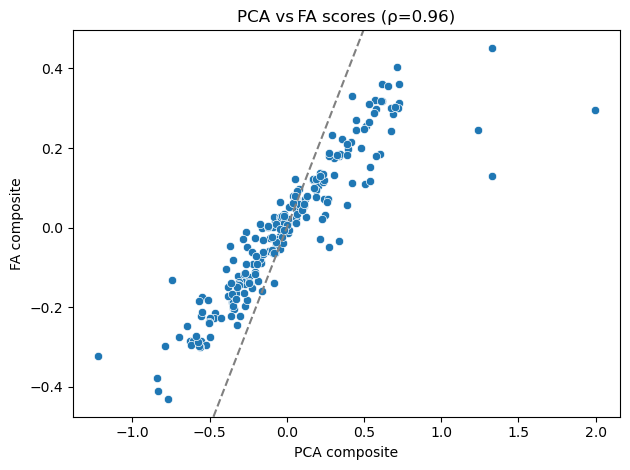

In [4]:
from scipy.stats import spearmanr
import seaborn as sns, matplotlib.pyplot as plt

rho, p = spearmanr(df["final_score_pca"], df["final_score_fa"])
print(f"Spearman ρ = {rho:.3f}  (p = {p:.3g})")

sns.scatterplot(x="final_score_pca", y="final_score_fa", data=df)
plt.axline((0,0), slope=1, color="gray", ls="--")
plt.xlabel("PCA composite"); plt.ylabel("FA composite")
plt.title(f"PCA vs FA scores (ρ={rho:.2f})")
plt.tight_layout(); plt.show()


In [5]:
df["rank_shift"] = df["rank_pca"] - df["rank_fa"]

# Top movers up/down
movers_up   = df.sort_values("rank_shift", ascending=False).head(10)
movers_down = df.sort_values("rank_shift").head(10)

print("\nBiggest climbers under FA:\n", movers_up[["rank_pca","rank_fa"]])
print("\nBiggest drops under FA:\n", movers_down[["rank_pca","rank_fa"]])



Biggest climbers under FA:
       rank_pca  rank_fa
iso3                   
LKA      184.0    131.0
TLS      211.0    159.0
MAF      114.0     73.0
MDA      157.0    116.0
LIE       90.0     50.0
MHL      165.0    125.0
ZAF      187.0    151.0
LCA      140.0    106.0
FSM      176.0    145.0
ATG      124.0     94.0

Biggest drops under FA:
       rank_pca  rank_fa
iso3                   
GUY       43.0    127.0
IND       50.0    133.0
DZA       60.0    123.0
UKR        2.0     48.0
LBN      123.0    165.0
SSD       39.0     79.0
RUS       59.0     97.0
TGO      137.0    173.0
ARM       54.0     89.0
OMN       23.0     54.0


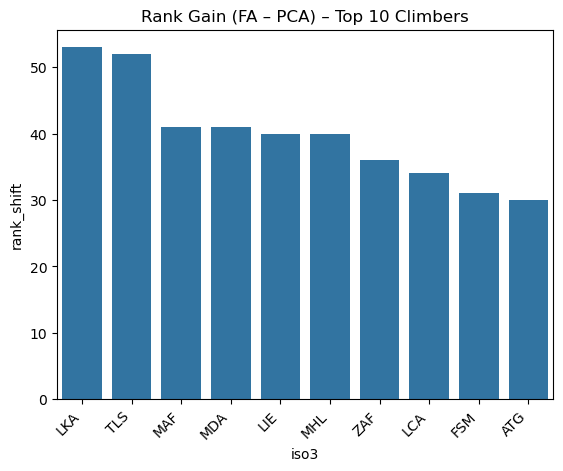

In [6]:
sns.barplot(x=movers_up.index, y=movers_up["rank_shift"])
plt.title("Rank Gain (FA – PCA) – Top 10 Climbers")
plt.xticks(rotation=45, ha="right"); plt.show()


In [20]:
import pandas as pd
from scipy.stats import spearmanr
import pycountry

# 1) Load PCA and FA score files
pca_df = pd.read_csv('notebooks/data/clean/final_pca_index.csv').set_index('iso3')
fa_df  = pd.read_csv('notebooks/data/clean/final_fa_index.csv').set_index('iso3')

# 2) Read the HDR HDI table without headers
hdr_raw = pd.read_csv(
    'notebooks/data/raw/HDR25_Statistical_Annex_HDI_Table.csv',
    header=None,
    encoding='latin1'
)

# 3) Detect start of HDI data (rank in col 0, HDI in col 2)
start_idx = None
for idx, (r0, r2) in hdr_raw[[0, 2]].iterrows():
    try:
        int(r0)
        float(r2)
        start_idx = idx
        break
    except:
        continue
if start_idx is None:
    raise RuntimeError("Couldn't locate HDI start row")

# 4) Slice country name (col 1) & HDI (col 2)
hdr_data = hdr_raw.iloc[start_idx:, [1, 2]].copy()
hdr_data.columns = ['country_name', 'hdi']
hdr_data['hdi'] = pd.to_numeric(hdr_data['hdi'], errors='coerce')

# 5) Map country names to ISO3
def country_to_iso3(name):
    try:
        return pycountry.countries.lookup(str(name).strip()).alpha_3
    except:
        return None

hdr_data['iso3'] = hdr_data['country_name'].map(country_to_iso3)

# 6) Build the HDI series
hdi = hdr_data.dropna(subset=['iso3', 'hdi']).set_index('iso3')['hdi']

# 7) Compute Spearman’s ρ
results = {}
for label, df_scores in [("PCA", pca_df), ("FA", fa_df)]:
    if 'final_score' not in df_scores.columns:
        raise KeyError(f"'final_score' not found in {label} file; columns: {df_scores.columns.tolist()}")
    common = df_scores.index.intersection(hdi.index)
    rho, _ = spearmanr(df_scores.loc[common, 'final_score'], hdi.loc[common])
    results[label] = rho

# Print results
for label, rho in results.items():
    print(f"Spearman with HDI – {label}: {rho:.3f}")


Spearman with HDI – PCA: 0.867
Spearman with HDI – FA: 0.928
